In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [0]:
%matplotlib inline

In [0]:
SETUP = True

In [0]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)


     |████████████████████████████████| 296kB 5.0MB/s 
     |████████████████████████████████| 153kB 35.2MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 552kB 40.1MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 122kB 45.3MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 102kB 3.0MB/s 
     |████████████████████████████████| 747kB 10.4MB/s 
     |████████████████████████████████| 993kB 3.5MB/s 
0.3.9
2.1.0-rc1


In [0]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the env

In [0]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
MODEL_URL = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"

In [0]:
model = hub.load(MODEL_URL)

In [0]:
def load_image_from_url(url: str) -> np.ndarray:
    filename = os.path.basename(url)
    image_path = keras.utils.get_file(filename, url)
    image = plt.imread(image_path).astype(np.float32)
    return image

In [0]:
def crop_center(image):
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

In [0]:
def prepare_image(
    url: str, size: Optional[Tuple[int, int]] = None, preserve_aspect_ratio: bool = True
):
    image = load_image_from_url(url)[np.newaxis, ...]
    image = image / 255
    image = crop_center(image)
    if size:
        image = tf.image.resize(image, size, preserve_aspect_ratio=preserve_aspect_ratio)
    return image

In [0]:
def show(images: List[np.ndarray], cols: int = 6, size: int = 5):
    if len(images) < cols:
        cols = len(images)
    rows = math.ceil(len(images) / cols)
    figsize = (size * cols, size * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)
    for i, x in enumerate(images):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(x[0])
        ax[idx].set_title(i)


## Style image

In [0]:
style_image_urls = [
    "https://i.imgur.com/RlQI0g0.jpg",
    "https://i.imgur.com/dMXz1Jc.jpg",
    "https://i.imgur.com/IpLHnhC.jpg",
    "https://i.imgur.com/hxOa9RV.jpg",
    "https://i.imgur.com/jIQxkjr.jpg",
    "https://i.imgur.com/8wc85Fr.jpg",
]

In [0]:
style_images = [
    tf.nn.avg_pool(
        prepare_image(style_image_url, size=(256, 256)),
        ksize=[2, 2],
        strides=[1, 1],
        padding="SAME",
    )
    for style_image_url in style_image_urls
]


In [0]:
%matplotlib inline

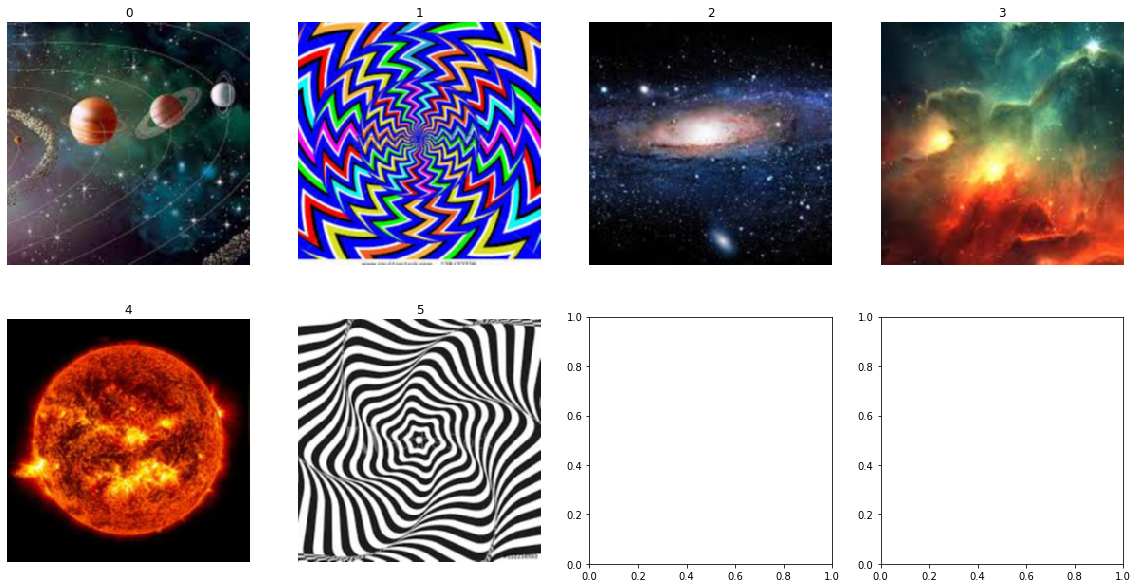

In [44]:
show(style_images, cols=4)

## Content images

In [0]:
content_image_urls = [
    "https://i.imgur.com/uz7t2Tn.jpg",
    "https://i.imgur.com/YHNAzUQ.jpg",
    "https://i.imgur.com/XpRkb9L.jpg",
    "https://i.imgur.com/cbQDmLU.jpg",
    "https://i.imgur.com/vfsUnxe.jpg",
    "https://i.imgur.com/H6ScqnM.jpg",
    "https://i.imgur.com/E5M231w.jpg",
    "https://i.imgur.com/gl3QRBo.jpg",
    "https://i.imgur.com/oIGnXUH.jpg",
    "https://i.imgur.com/4wdBHEp.jpg",

]

In [0]:
content_images = [prepare_image(content_image_url) for content_image_url in content_image_urls]

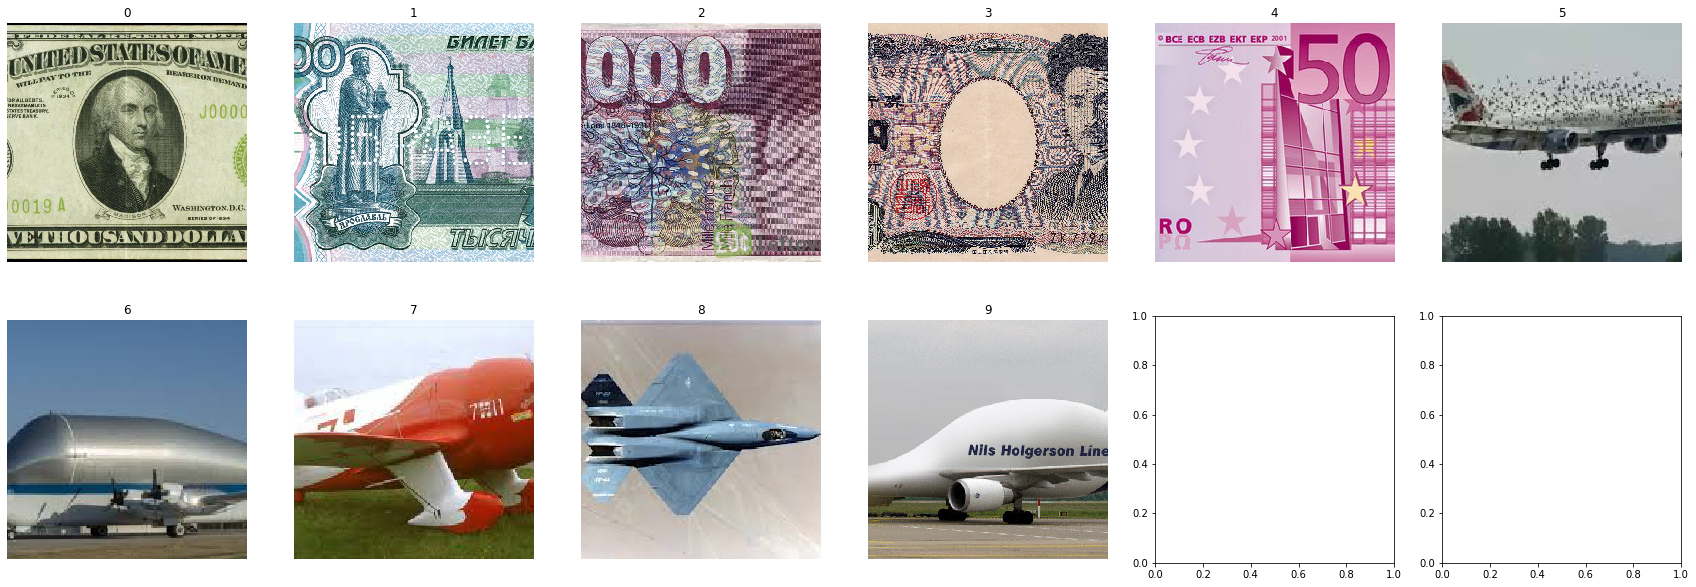

In [47]:
show(content_images)

In [48]:
outputs = [model(tf.constant(content_image), tf.constant(style_image))[0] for style_image in style_images for content_image in progress_bar(content_images)]

In [49]:
show(outputs, cols=5)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
style_images_2 = [
    tf.nn.avg_pool(
        prepare_image(style_image_url, size=(8, 8)),
        ksize=[1, 1],
        strides=[1, 1],
        padding="SAME",
    )
    for style_image_url in style_image_urls
]


In [0]:
content_images_2 = [prepare_image(content_image_url) for content_image_url in content_image_urls]

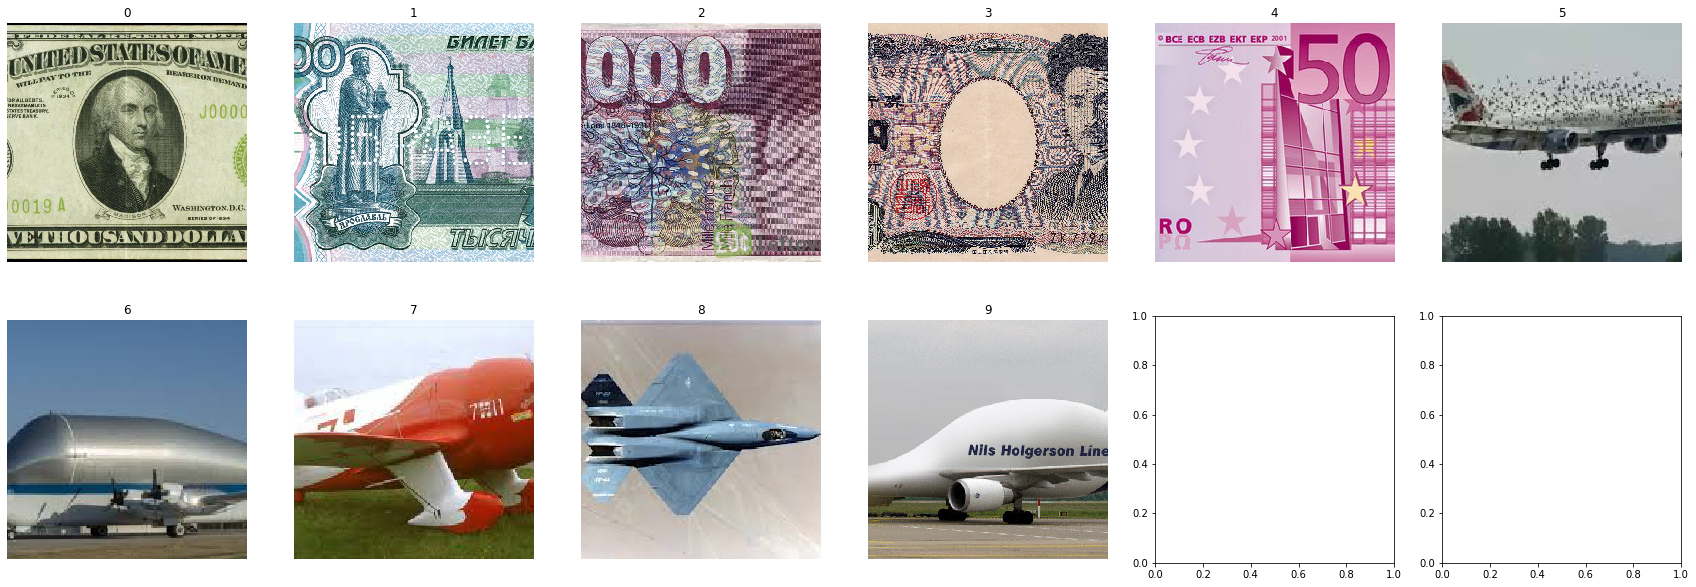

In [66]:
show(content_images_2)

In [0]:
outputs_2 = [model(tf.constant(content_image), tf.constant(style_image))[0] for style_image in style_images_2 for content_image in progress_bar(content_images_2)]

In [63]:
show(outputs_2, cols=5)

Output hidden; open in https://colab.research.google.com to view.